In [ ]:
# Citations
# <cite data-cite="datarray_meeting">(Granger, 2013)</cite>
# <strong data-cite="datarray_meeting">(Granger, 2013)</strong>
# <cite data-cite="Bherer2017"></cite>

#  Convert to pdf: 
# jupyter nbconvert --to pdf --template template.tplx --no-input 20211117_LocationPatterns1.ipynb  

In [2]:
# Initiate notebook with packages
# -------------------------------

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import rpy2.rinterface
%load_ext rpy2.ipython
import random 
import scipy.stats
# import math
from plotnine import  ggplot, data, geom_histogram, aes, geom_bar, geom_rect,geom_hline, scale_x_discrete,  theme, element_text, ggtitle, xlab, ylab, facet_wrap, geom_point, stat_smooth, annotate, geom_text, geom_boxplot, geom_col, facet_grid
import warnings
warnings.filterwarnings('ignore')


In [4]:

# Set working directory
# ------------------------------
os.chdir("../../")

# Background



In this report we try to answer to the question: are inversions less (or more) likely to become polymorphic under certain recombinatory contexts? 
Specifically, we test whether there is a tendency to avoid extremely high recombination rates (putative hotspots) and favor low-recombination regions (putative coldspots). 

In [148]:
# Set figure counter for text
# ------------------------------
figcounter = 1

# Load chromosome data
# -------------------------------

# gap = pd.read_csv('data/raw/gap.txt', sep = '\t', header = None )
# gap.set_axis(['bin','chrom','chromStart','chromEnd','ix','n','size','type','bridge'], axis = 1, inplace = True)

# band = pd.read_csv('data/raw/cytoBand.txt', sep = '\t', header = None )
# band.set_axis(['chrom','chromStart','chromEnd','name','gieStain'], axis = 1, inplace = True)

sizes = pd.read_csv('data/raw/chrSizes.txt', sep = '\t')

# genSize = pd.read_csv("data/use/BhererGeneticDistance.txt", sep = "\t", header = None)
# genSize.set_axis(["Chromosome", "Position", "Rate", "cM"] ,axis = 1, inplace = True)

# recRate = pd.read_csv("data/use/BhererAllChroms.txt", sep = "\t", header = None)
# recRate.set_axis(["Chromosome", "Position", "Rate", "cM"] ,axis = 1, inplace = True)

# Load repeat data
# -------------------------------

# segDups = pd.read_csv('data/raw/genomicSuperDups.txt', sep = '\t'  )

# Load and clean inversion data
# -------------------------------

inv = pd.read_csv('data/use/InversionsAnnotation_133Inv_20211117.csv', sep = '\t', skiprows=1, skip_blank_lines=True)
inv = inv.iloc[:,[0,1,2,11,12,13,14]]
inv = inv.dropna()

Ori_fixed =  inv["Origin"].replace(regex = ["NAHR.*"], value = "NAHR" )
Ori_fixed = Ori_fixed.replace(regex = ["NH.*"], value = "NH" )
inv["OriginFixed"] = Ori_fixed
inv["CenterPos"] = inv["BP1_1.1"] + ((inv["BP2_2.1"]- inv["BP1_1.1"] +1 )/2) -1 # now it is 0-based


print(f"""We will be analyzing {inv.shape[0]} inversions, {Ori_fixed[Ori_fixed == "NAHR"].count()} NAHR and {Ori_fixed[Ori_fixed == "NH"].count()} NH.""")


We will be analyzing 133 inversions, 54 NAHR and 79 NH.


# Extreme recombination rates calculation


One of our main concerns is how to define extreme recombination regions (ERRs). In pedigree-based maps analysis, it is a common practice to calculate the standarized recombination rate (SRR), which is obtained by relativizing each rate to the population mean recombination rate <cite data-cite="Bherer2017"></cite>. Usually, it is considered high recombination rate when SRR>10 <cite data-cite="Farre2013"></cite><cite data-cite="Kong2010"></cite>, which corresponds to the ~1% most extreme values in the distribution. In our case, we are using the population-based recombination map from <cite data-cite="Spenceeaaw9206"></cite>, and I will try to keep values as raw as possible to avoid unnecessary biases.

In [ ]:
# How extreme is SRR>10?

bhererMap = pd.read_csv("data/use/CEU_SRR.bed", sep = "\t", header = None)

from scipy import stats

# To know the answer, run:
# (100 - round(stats.percentileofscore(bhererMap[3], 10), 0))

In addition, I will explore multiple thresholds when defining ERRs to see how are inversions located relative to milder and harder hotspots and coldspots. 
<!-- As a visual reference, [FIGNUM] shows the distribution of recombination rates for the CEU population in the population-based map.  -->

In [ ]:
# Load recombination files list
# os.listdir("data/raw/hg19/KHV/")
chrom = "8"
pop="CEU"
sig = 0.999
namesig = "Quantile_"+str(sig)

genSize = pd.read_csv("data/raw/hg19/"+pop+"/"+pop+"_recombination_map_hapmap_format_hg19_chr_"+chrom+".txt", sep = "\t")

# genSize["Rate(cM/Mb)"].describe()

threshold = np.quantile(genSize["Rate(cM/Mb)"], sig)

genSize[namesig] = genSize["Rate(cM/Mb)"] > threshold

(
    ggplot()+
    geom_point(genSize, aes(x = "Position(bp)", y = "Rate(cM/Mb)", color = namesig))+
    geom_rect( inv[inv.Chr == "chr"+chrom], aes(xmax = "BP1_1.1", xmin = "BP2_2.1", ymax = np.inf , ymin=0,  fill = "OriginFixed"), alpha = 0.5)+
    geom_hline(yintercept =max(genSize["Rate(cM/Mb)"])+20, color = "gray", alpha = 0.5)+
    geom_point( inv[inv.Chr == "chr"+chrom], aes(x = "CenterPos", y = max(genSize["Rate(cM/Mb)"]+20), fill = "OriginFixed"),shape = 7 , size = 3)+
    ggtitle("Chromosome "+chrom+" in "+pop+" population")
)

# Association analysis with GAT

The genomic association tester (GAT) is a python package that makes permutation analyses to test for association between sets of genomic intervals.
One or more tracks of segments and one or more tracks of annotations are required as input, and the program returns observed and expected number of overlapping nucleotides between the segments and the annotations, the corresponding fold-change, and the empirical p-value and q-value, among other useful measurements. 

The same randomization of a set of segments (e.g. inversions) can be compared against multiple annotations (e.g. hotspots and coldspots), to test for a significant enrichment of any annotation in the segments, and different segments can be tested for enrichment of the same annotation. In either case, even when significant enrichments are found, inferences about the difference between two fold-change measurements are not possible. For exampe, we can not say with statistical confidence that a segment 2-fold significantly enriched in annotation A and 3-fold in annotation B is more enriched in B elements, because A elements could be more abundant in the genome. To contrast fold enrichments of different sets of segments against the same annotation, there is a tool implemented in GAT. 

In [144]:
# Additional files for GAT
# Question: The question we ask is whether within the genome (== WORKSPACE), 
# (SRF binding events == INVERSIONS == SEGMENTS) 
# are in regions of (open chromatin == HIGH REC == ANNOTATIONS) as identified by (DNAse I hypersensitive sites == ERRs).
# WORKSPACE
sizes["start"] = 0
workspace = sizes[["Chromosome", "start", "Totallength(bp)"]]
workspace

workspace.to_csv("report/20211213_LocationPatterns2/analysis/contigs.bed", sep = "\t", header=False, index = False)

# SEGMENTS (inversions)
segments = inv[["Chr", "BP1_1.1", "BP2_2.1", "INV"]]
segments_NH = inv[inv["OriginFixed"] == "NH"][["Chr", "BP1_1.1", "BP2_2.1", "INV"]]
segments_NAHR = inv[inv["OriginFixed"] == "NAHR"][["Chr", "BP1_1.1", "BP2_2.1", "INV"]]

segments.to_csv("report/20211213_LocationPatterns2/analysis/segments.bed", sep = "\t", header=False, index = False)
segments_NH.to_csv("report/20211213_LocationPatterns2/analysis/segments_NH.bed", sep = "\t", header=False, index = False)
segments_NAHR.to_csv("report/20211213_LocationPatterns2/analysis/segments_NAHR.bed", sep = "\t", header=False, index = False)

# ANNOTATIONS (ERRs)
recRates = pd.read_csv("report/20211213_LocationPatterns2/analysis/CEU_recombination_map_hg19_allChr.bed", sep = "\t")
recRates.set_axis(["Chrom", "start", "end", "recrate_base_gen"], axis = 1, inplace= True)

pvals = [0.001, 0.01, 0.05, 0.95, 0.99,0.999]

annotations = DataFrame()

for sig in pvals:

    threshold = np.quantile(recRates["recrate_base_gen"], sig)

    if sig > 0.5:
        #  Hotspots
        namesig = "Hotspot_"+str( sig )
        recRates[namesig] = recRates["recrate_base_gen"] > threshold
    else :
        # Coldspots
        namesig = "Coldspot_"+str(sig)
        recRates[namesig] = recRates["recrate_base_gen"] < threshold

    subannot = recRates[recRates[namesig]][["Chrom", "start", "end"]]
    subannot["trackName"] = namesig
    annotations = annotations.append(subannot, ignore_index=True)

annotations.to_csv("report/20211213_LocationPatterns2/analysis/annotations.bed", sep = "\t", header=False, index = False)


# gat-run.py --segments=segments.bed --annotations=annotations.bed --workspace=contigs.bed --num-samples=10000 --log=gat.log > gat.tsv 

# This analysis
# gat-run.py --segments=analysis/segments.bed --annotations=analysis/annotations.bed --workspace=analysis/contigs.bed --num-samples=100000 --log=analysis/gat.log > analysis/gat.tsv 
# gat-run.py --segments=analysis/segments_NH.bed --annotations=analysis/annotations.bed --workspace=analysis/contigs.bed --num-samples=100000 --log=analysis/gat.log > analysis/gat_NH.tsv 
# gat-run.py --segments=analysis/segments_NAHR.bed --annotations=analysis/annotations.bed --workspace=analysis/contigs.bed --num-samples=100000 --log=analysis/gat.log > analysis/gat_NAHR.tsv 


In [145]:
# Analysis of GAT output

gatResult = pd.read_csv("report/20211213_LocationPatterns2/analysis/gat.tsv", sep = "\t", header = 0)
gatResult_NH = pd.read_csv("report/20211213_LocationPatterns2/analysis/gat_NH.tsv", sep = "\t", header = 0)
gatResult_NAHR = pd.read_csv("report/20211213_LocationPatterns2/analysis/gat_NAHR.tsv", sep = "\t", header = 0)

gatResult = gatResult.append(gatResult_NH, ignore_index=True)
gatResult = gatResult.append(gatResult_NAHR, ignore_index=True)


gatResult["track"] = gatResult.track_nsegments.replace([133, 79, 54], ["all", "NH", "NAHR"])

gatResult["p-value"] = ""
gatResult.loc[gatResult['pvalue'] <=0.05, 'p-value'] = "*"
gatResult.loc[gatResult['pvalue'] <=0.01, 'p-value'] = "**"
gatResult.loc[gatResult['pvalue'] <=0.001, 'p-value'] = "***"

gatResult["q-value"] = ""
gatResult.loc[gatResult['qvalue'] <=0.05, 'q-value'] = "*"
gatResult.loc[gatResult['qvalue'] <=0.01, 'q-value'] = "**"
gatResult.loc[gatResult['qvalue'] <=0.001, 'q-value'] = "***"


I have tested GAT using the CEU population historical recombination measurements and 100000 permutations. The annotations were high recombination regions (Hotspots) above the 5, 1, and 0.1% most extreme and low recombination regions (Coldspots) below the 5, 1 and 0.1% most extreme. The most remarkable results have been summarized in Figure 1. 



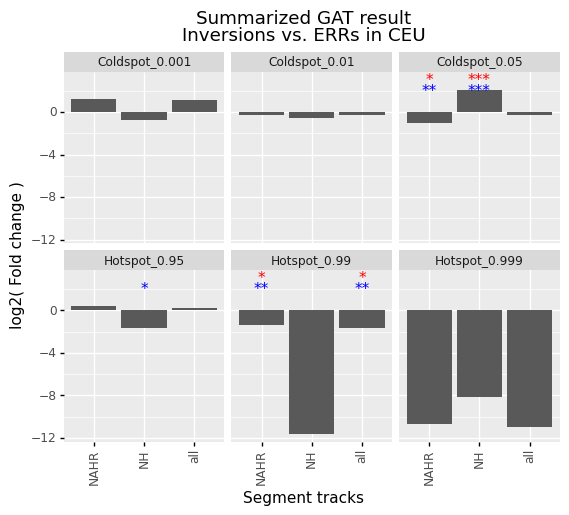

<ggplot: (8769247801766)>

In [146]:

(
    ggplot(gatResult)+
    geom_bar(aes(x = "track", y = "l2fold"), stat="identity")+
    geom_text(aes(x = "track", y = max(gatResult["l2fold"]), label = "p-value"), color ="blue")+
    geom_text(aes(x = "track", y = max(gatResult["l2fold"])+1, label = "q-value"), color = "red")+
    facet_wrap("annotation")+
    ylab("log2( Fold change )")+
    xlab("Segment tracks")+
    theme( axis_text_x = element_text(angle = 90, vjust = 1))+
    ggtitle("Summarized GAT result\nInversions vs. ERRs in CEU")

)

In [149]:
print(f"""Figure {figcounter}: Summary of GAT results when testing the overlap between inversions and ERRs. Remember that the magnitudes of fold-changes are not comparable. Significant p-values are indicated in blue and significant q-values in red. """) 
figcounter+=1



Figure 1: Summary of GAT results when testing the overlap between inversions and ERRs. Remember that the magnitudes of fold-changes are not comparable. Significant p-values are indicated in blue and significant q-values in red. 


NAHR inversions tend to avoid extreme coldspots, probably because higher recombination rates favor their generation. NH inversions, on the other hand, are significantly enriched in extremely low recombination regions, which may be favorable because that way the probability of generating chromosomal aberrations during meiosis is lower.

Regarding hotspots, there are some non-significant fold changes < -8. In all four cases, the observed overlap between segment and track is 0, but the corresponding confidence interval is very broad and includes 0 as an expected value. This is caused by the scarcity of hotspots above the 0.1% most extreme in the 'Hotspot_0.999' panel, and by the small size of NH inversions in the 'Hotspot_0.99' panel, both of which make likely an overlap of 0 nucleotides between tracks. Both NH and NAHR inversions seem to avoid regions that have the highest 1% recombination rates in the genome.


# Limitations and further work

This analysis is only a proof of concept, and many adjustments are still required, some of which may need discussion: 

* As stated in the GAT documentation, if the section of the genome to use as a base for the permutations (workspace) is too large, fold enrichment values will be too optimistic. The workspace should be limited to those regions where the analysis is actually feasible and regions where any of the tracks could not be calculated should be excluded. As a starting point, regions where inversion detection is not possible and regions where the recombination rate windows are very large, indicating low SNP density and less reliable estimates, should be discarded. 
* Properties of the sequence that are potentially correlated with the segment of interest and the annotations, but that are not interesting in out experiment (e.g. GC content, repeat density, gene/exon density), can be controlled by adding them as isochore tracks. These will be used to divide the workspace into smaller segments with similar properties.
* HsInv0501 due to its large size and HsInv0573 as a recombination-increasing factor, can be confounding, so we should test if removing them alters the identified patterns. 

Once the enrichment analysis is adjusted to our needs, I will repeat it for multiple populations, which should not require long computing times, because GAT is fast and parallelizable. This will add robustness to our result by confirming whether this pattern is consistent along populations or meta-populations. 

> **Note:** before the analysis of each opulation, we should delete those inversions with frequency 0 from the segments track. 

